In [32]:
import random
import numpy as np
import torch
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1) #set random seed for cpu
torch.cuda.manual_seed(1) #set random seed for current gpu
torch.cuda.manual_seed_all(1) #set random seed for all gpus

In [5]:
if torch.cuda.is_available():
    use_cuda = True
    torch.cuda.set_device(7)
else:
    use_cuda = False
print("CUDA available? " + str(use_cuda))
if use_cuda:
    print("Current device: %d" % torch.cuda.current_device())

CUDA available? True
Current device: 7


# Helper Functions

In [8]:
def read_useranditemlist(path):
    userlist = pd.read_csv(path + ".userlist", header=None, squeeze=True).values.tolist()
    itemlist = pd.read_csv(path + ".itemlist", header=None, squeeze=True).values.tolist()
    
    return userlist, itemlist

In [26]:
def reduce_dimensions(data, dim=2):
    tsne = TSNE(n_components=dim)
    latent = tsne.fit_transform(data)
    latent = StandardScaler().fit_transform(latent)
    
    return latent

In [29]:
def plotting(path, data, save_as=False):
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1], s=1)
    plt.xlabel(r"Latent dimension $x$")
    plt.ylabel(r"Latent dimension $y$")
    plt.ylim([-2.5, 2.5])
    plt.xlim([-2.5, 2.5])
    plt.tight_layout()
    if save_as:
        plt.savefig(path + "/" + save_as, dpi=300)

In [16]:
def get_item_embedding(path_to_model, users, item_id):
    location = "cuda:" + str(torch.cuda.current_device())
    net = torch.load(path_to_model, map_location=location)
    
    params = net.state_dict()
    U = params["metarecommender.user_embedding.weight"]
    M = params["metarecommender.memory"]
    
    item_embeddings = []
    for uid in users:
        c_u = torch.matmul(U[uid], M)

        hidden_layer = net.metarecommender.hidden_layer_3
        embedding_layer1 = net.metarecommender.emb_layer_1
        embedding_layer2 = net.metarecommender.emb_layer_2
        item_num = net.metarecommender.item_num
        item_mem_num = net.metarecommender.item_mem_num
        item_emb_size = net.metarecommender.item_emb_size
        item_embedding_u = net.metarecommender.get_item_embedding(hidden_layer, embedding_layer1, embedding_layer2, c_u, item_num, item_mem_num, item_emb_size)[0, :, :].detach().cpu().numpy()
        
        item_embeddings.append(item_embedding_u)
        
    item_embeddings = np.swapaxes(np.array(item_embeddings), 0, 1)
    return item_embeddings[item_id]

In [19]:
def get_weights(path_to_model, users):
    location = "cuda:" + str(torch.cuda.current_device())
    net = torch.load(path_to_model, map_location=location)
    
    params = net.state_dict()
    U = params["metarecommender.user_embedding.weight"]
    M = params["metarecommender.memory"]
    
    hidden_weights1, hidden_weights2 = [], []
    for uid in userlist:
        c_u = torch.matmul(U[uid], M)
        hidden_layer_1 = net.metarecommender.hidden_layer_1
        weight_layer_1 = net.metarecommender.weight_layer_1
        bias_layer_1 = net.metarecommender.bias_layer_1
        hidden_layer_2 = net.metarecommender.hidden_layer_2
        weight_layer_2 = net.metarecommender.weight_layer_2
        bias_layer_2 = net.metarecommender.bias_layer_2
        item_emb_size = net.metarecommender.item_emb_size
        
        weights1, _ = net.metarecommender.get_one_layer(hidden_layer_1, weight_layer_1, bias_layer_1, c_u, item_emb_size, int(item_emb_size/4))
        weights1 = weights1.reshape(1, -1)
        
        weights2, _ = net.metarecommender.get_one_layer(hidden_layer_2, weight_layer_2, bias_layer_2, c_u, int(item_emb_size / 4), 1)
        weights2 = weights2.reshape(1, -1)
        
        hidden_weights1_u = weights1.detach().cpu().numpy()
        hidden_weights2_u = weights2.detach().cpu().numpy()
        hidden_weights1.append(hidden_weights1_u)
        hidden_weights2.append(hidden_weights2_u)
        
    return np.array(hidden_weights1)[:, 0, :], np.array(hidden_weights2)[:, 0, :]

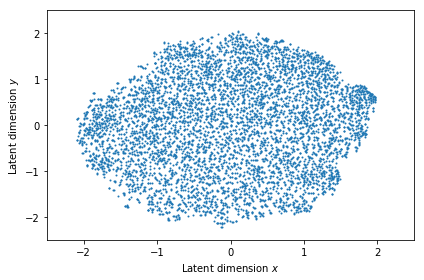

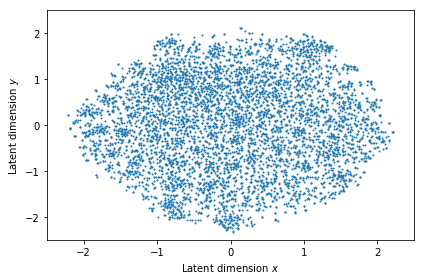

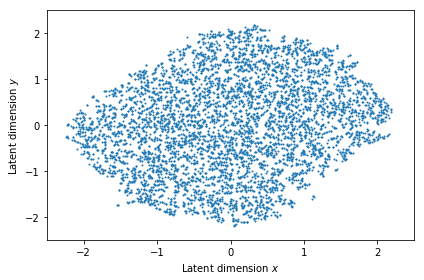

In [33]:
userlist, itemlist = read_useranditemlist("data/ml")
item_embedding = get_item_embedding("experiments/meta/ml/beta_10p.model", userlist, item_id=482)
weights1, weights2 = get_weights("experiments/meta/ml/beta_10p.model", userlist)

plotting("experiments/meta/ml", reduce_dimensions(item_embedding), save_as="emb_10p")
plotting("experiments/meta/ml", reduce_dimensions(weights1), save_as="w1_10p")
plotting("experiments/meta/ml", reduce_dimensions(weights2), save_as="w2_10p")